# Importing data

### Importing data 1

In [1]:

import glob
import pandas as pd

data = []

DATA_PATH = '../TECH2-Exam/data/DayAheadPrices_12.1.D'

files = glob.glob(f'{DATA_PATH}/*')

for file in files:
    fn = pd.read_csv(file, sep ='\t', parse_dates=['DateTime'], index_col='DateTime')
    data.append(fn)

df = pd.concat(data).sort_index()
df = df[['ResolutionCode','MapCode','Price']]
df = df.query('MapCode == "NO2" or MapCode == "DE_LU" and ResolutionCode == "PT60M"')
df


,ResolutionCode,MapCode,Price
DateTime,,,
2019-01-01 00:00:00,PT60M,NO2,49.25
2019-01-01 00:00:00,PT60M,DE_LU,10.07
2019-01-01 01:00:00,PT60M,DE_LU,-4.08
2019-01-01 01:00:00,PT60M,NO2,49.17
2019-01-01 02:00:00,PT60M,DE_LU,-9.91
...,...,...,...
2023-12-31 21:00:00,PT60M,NO2,61.77
2023-12-31 22:00:00,PT60M,DE_LU,2.44
2023-12-31 22:00:00,PT60M,NO2,59.31


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


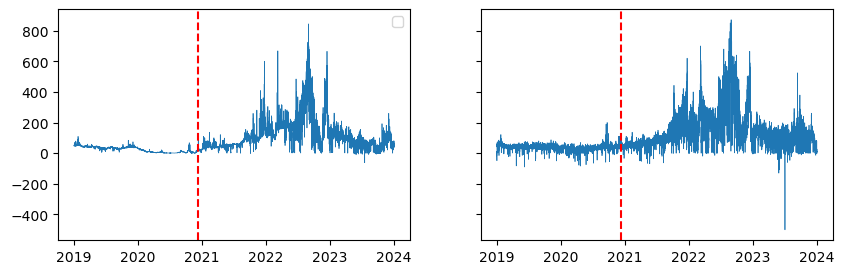

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))

x1 = df.query('MapCode == "NO2"')
xvalue1 = x1.index

y1 = x1['Price']

x2 = df.query('MapCode == "DE_LU"')
xvalue2 = x2.index

y2 = x2['Price']

axes[0].plot(xvalue1, y1, lw=0.5)


axes[1].plot(xvalue2, y2, lw=0.5)

axes[0].axvline(pd.to_datetime('2020-12-09'), ls='--', c='r')
axes[1].axvline(pd.to_datetime('2020-12-09'), ls='--', c='r')

axes[0].legend()

### Task 2

In [3]:
df = df.loc['2019':'2023'].copy()               # Restricting the data the period 2019-2023
df['Year'] = df.index.year                      # Creating a new index 'Year' containing only years in the restricted period

groups = df.groupby(['Year','MapCode'])         # Create a group, with the new index 'Year' and 'MapCode' (Norway or Germany)

table = groups.agg(                             # Creates a new table that calculate the required statistics
    Mean = ('Price', 'mean'),
    Median = ('Price', 'median'),
    Standard_deviation = ('Price', 'std'),
    Min = ('Price', 'min'),
    Max = ('Price', 'max'),
).round(2)
table                                           # Prints the table
#table.to_excel('table_task2.xlsx')             # Makes a excel sheet with the new data table

Mean  Median  Standard_deviation     Min     Max
Year MapCode                                                    
2019 DE_LU     37.67   38.06               15.52  -90.01  121.46
     NO2       39.26   38.81                8.23    5.86  109.45
2020 DE_LU     30.47   30.99               17.50  -83.94  200.04
     NO2        9.29    6.95                8.26   -1.73   99.92
2021 DE_LU     96.85   75.48               73.68  -69.00  620.00
     NO2       75.11   59.34               47.22   -1.97  600.16
2022 DE_LU    235.44  208.34              142.82  -19.04  871.00
     NO2      211.28  181.13              125.85    0.04  844.00
2023 DE_LU     95.18   98.02               47.58 -500.00  524.27
     NO2       79.44   80.46               36.28  -61.84  261.85

#### Importing dataset 2

In [4]:
data = []

DATA_PATH = '../TECH2-Exam/data/PhysicalFlows_12.1.G'

files = glob.glob(f'{DATA_PATH}/*')

for file in files:
    fn = pd.read_csv(file, sep ='\t', parse_dates=['DateTime'], index_col='DateTime')
    data.append(fn)

df2 = pd.concat(data).sort_index()
df2 = df2.query('(InMapCode == "NO2" and OutMapCode == "DE_LU") or (InMapCode == "DE_LU" and OutMapCode == "NO2")')
df2

,InMapCode,OutMapCode,FlowValue
DateTime,,,
2020-09-01 22:00:00,DE_LU,NO2,0.0000
2020-09-01 22:00:00,NO2,DE_LU,0.0000
2020-09-01 23:00:00,DE_LU,NO2,0.0000
2020-09-01 23:00:00,NO2,DE_LU,0.0000
2020-09-02 00:00:00,DE_LU,NO2,0.0000
...,...,...,...
2023-12-31 21:00:00,DE_LU,NO2,0.0000
2023-12-31 22:00:00,NO2,DE_LU,1350.5975
2023-12-31 22:00:00,DE_LU,NO2,0.0000


### Task 3

In [5]:
df2['Year'] = df2.index.year

df2['Indicator'] = df2.apply(lambda x: 'Import' if x['InMapCode'] == 'NO2' else 'Export', axis = 1)

df2

,InMapCode,OutMapCode,FlowValue,Year,Indicator
DateTime,,,,,
2020-09-01 22:00:00,DE_LU,NO2,0.0000,2020,Export
2020-09-01 22:00:00,NO2,DE_LU,0.0000,2020,Import
2020-09-01 23:00:00,DE_LU,NO2,0.0000,2020,Export
2020-09-01 23:00:00,NO2,DE_LU,0.0000,2020,Import
2020-09-02 00:00:00,DE_LU,NO2,0.0000,2020,Export
...,...,...,...,...,...
2023-12-31 21:00:00,DE_LU,NO2,0.0000,2023,Export
2023-12-31 22:00:00,NO2,DE_LU,1350.5975,2023,Import
2023-12-31 22:00:00,DE_LU,NO2,0.0000,2023,Export


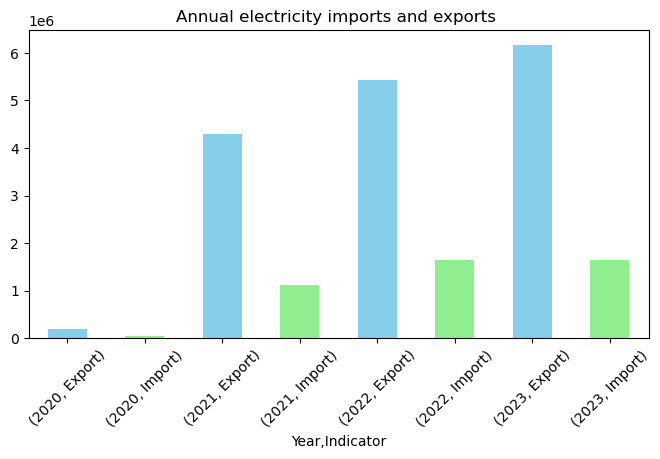

In [6]:
annual_sum = df2.groupby(['Year','Indicator'])['FlowValue'].sum()

fig, ax = plt.subplots(figsize=(8,4))

annual_sum.plot(kind='bar', color=['skyblue', 'lightgreen'])
ax.set_title('Annual electricity imports and exports ')
ax.tick_params(axis='x', rotation=45)

